<a href="https://colab.research.google.com/github/Salmania27/PatientSchedule/blob/main/PKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dataset





In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
pasien_path = '/content/drive/MyDrive/KULIAH/pasien2.xlsx'

In [3]:
import pandas as pd

data = pd.read_excel('/content/drive/MyDrive/KULIAH/pasien2.xlsx')

In [4]:
data.head()

,Encounter ID,Doctor ID,Clinic Location,Patient ID,Appointment Date/Time,Appointment Type,Appointment Length,Reason For Visit,Priority,Visit Status
0,10001,881452,Marina Del Rey,16195,2022-01-03 08:00:00,New Patient,25,Blood test,2.0,No-Show
1,10002,881452,Marina Del Rey,19287,2022-01-03 08:30:00,New Patient,25,General consultation,3.0,Completed
2,10003,881452,Marina Del Rey,11941,2022-01-03 08:45:00,New Patient,40,Diabetes consultation,2.0,Completed
3,10004,881452,Marina Del Rey,17461,2022-01-03 09:00:00,Follow-up Visit,25,Stomach emergency,1.0,Completed
4,10005,881452,Marina Del Rey,15477,2022-01-03 09:15:00,New Patient,40,Blood pressure check,2.0,Completed


In [5]:
print(data.dtypes)

Encounter ID                      int64
Doctor ID                         int64
Clinic Location                  object
Patient ID                        int64
Appointment Date/Time    datetime64[ns]
Appointment Type                 object
Appointment Length                int64
Reason For Visit                 object
Priority                        float64
Visit Status                     object
dtype: object


In [6]:
data.rename(columns={'Encounter ID': 'Encounter_ID',
                     'Doctor ID': 'Doctor_ID',
                     'Patient ID': 'Patient_ID',
                     'Appointment Date/Time': 'Appointment_Time',
                     'Appointment Type': 'Appointment_Type',
                     'Appointment Length': 'Duration',
                     'Reason For Visit' : 'Complaint' }, inplace=True)

print(data.columns)

Index(['Encounter_ID', 'Doctor_ID', 'Clinic Location', 'Patient_ID',
       'Appointment_Time', 'Appointment_Type', 'Duration', 'Complaint',
       'Priority', 'Visit Status'],
      dtype='object')


In [7]:
# Mengubah Appointment ke format datetime
data['Appointment_Time'] = pd.to_datetime(data['Appointment_Time'], errors='coerce')

In [8]:
# Konversi kolom durasi ke format timedelta
data['Duration'] = pd.to_timedelta(data['Duration'], unit='m')

print(data.dtypes)

Encounter_ID                  int64
Doctor_ID                     int64
Clinic Location              object
Patient_ID                    int64
Appointment_Time     datetime64[ns]
Appointment_Type             object
Duration            timedelta64[ns]
Complaint                    object
Priority                    float64
Visit Status                 object
dtype: object


In [9]:
# Tambahkan kolom waktu selesai (End_Time)
data['End_Time'] = data['Appointment_Time'] + data['Duration']

In [10]:
data.drop(['Encounter_ID','Doctor_ID', 'Clinic Location'], axis=1, inplace=True)

print(data.head())

   Patient_ID    Appointment_Time Appointment_Type        Duration  \
0       16195 2022-01-03 08:00:00      New Patient 0 days 00:25:00   
1       19287 2022-01-03 08:30:00      New Patient 0 days 00:25:00   
2       11941 2022-01-03 08:45:00      New Patient 0 days 00:40:00   
3       17461 2022-01-03 09:00:00  Follow-up Visit 0 days 00:25:00   
4       15477 2022-01-03 09:15:00      New Patient 0 days 00:40:00   

               Complaint  Priority Visit Status            End_Time  
0             Blood test       2.0      No-Show 2022-01-03 08:25:00  
1   General consultation       3.0    Completed 2022-01-03 08:55:00  
2  Diabetes consultation       2.0    Completed 2022-01-03 09:25:00  
3      Stomach emergency       1.0    Completed 2022-01-03 09:25:00  
4   Blood pressure check       2.0    Completed 2022-01-03 09:55:00  


In [11]:
data_sorted = data.sort_values(by='End_Time')
print("\nData setelah diurutkan berdasarkan End_Time:\n", data_sorted)


Data setelah diurutkan berdasarkan End_Time:
     Patient_ID    Appointment_Time Appointment_Type        Duration  \
0        16195 2022-01-03 08:00:00      New Patient 0 days 00:25:00   
1        19287 2022-01-03 08:30:00      New Patient 0 days 00:25:00   
2        11941 2022-01-03 08:45:00      New Patient 0 days 00:40:00   
3        17461 2022-01-03 09:00:00  Follow-up Visit 0 days 00:25:00   
4        15477 2022-01-03 09:15:00      New Patient 0 days 00:40:00   
..         ...                 ...              ...             ...   
76       18173 2022-01-10 05:00:00      New Patient 0 days 00:40:00   
77       17097 2022-01-10 05:30:00  Follow-up Visit 0 days 00:25:00   
78       11129 2022-01-10 05:45:00  Follow-up Visit 0 days 00:25:00   
79       13891 2022-01-10 06:00:00  Follow-up Visit 0 days 00:15:00   
80       16952 2022-01-10 06:15:00      New Patient 0 days 00:45:00   

                Complaint  Priority Visit Status            End_Time  
0              Blood test    

## Optimasi Penjadwalan Pasien

In [20]:
from datetime import datetime

# Waktu kerja harian
working_hours = {
    'Monday': ('08:00:00', '18:00:00'),
    'Tuesday': ('08:00:00', '18:00:00'),
    'Wednesday': ('08:00:00', '18:00:00'),
    'Thursday': ('08:00:00', '18:00:00'),
    'Friday': ('08:00:00', '15:00:00'),
    'Saturday': ('08:00:00', '15:00:00'),
    'Sunday': ('08:00:00', '15:00:00')
}

def get_working_hours_for_day(day_name):
    start_str, end_str = working_hours.get(day_name, (working_hours)) # Default jika hari tidak ditemukan
    start_time = pd.Timestamp(start_str).time()
    end_time = pd.Timestamp(end_str).time()
    return start_time, end_time

In [21]:
# Algoritma greedy untuk memilih pasien sebanyak mungkin dalam satu hari
def greedy_schedule_per_day(data_sorted):
    daily_schedules = {}
    # Mengambil tanggal unik dari kolom 'Appointment_Time'
    unique_dates = data_sorted['Appointment_Time'].dt.date.unique()

    def is_within_working_hours(end_time, start_time_of_day, end_time_of_day):
        # Cek apakah end_time dalam batas jam kerja hari itu
        return start_time_of_day <= end_time.time() <= end_time_of_day

    for day in unique_dates:
        day_name = pd.Timestamp(day).day_name()
        start_time_of_day, end_time_of_day = get_working_hours_for_day(day_name)

        # Menggabungkan tanggal dan waktu mulai kerja
        last_end_time = datetime.combine(day, start_time_of_day)
        daily_schedules[day] = []  # Initialize an empty list for each day

        for index, row in data_sorted.iterrows():
            if row['Appointment_Time'].date() == day:
                if row['Appointment_Time'] >= last_end_time and is_within_working_hours(row['End_Time'], start_time_of_day, end_time_of_day):
                    # Tambahkan ke jadwal
                    daily_schedules[day].append({
                        'Patient_ID': row['Patient_ID'],
                        'Appointment_Time': row['Appointment_Time'],
                        'End_Time': row['End_Time'],
                        'Complaint': row['Complaint'],
                        'Priority': row['Priority']
                    })
                    last_end_time = row['End_Time']  # Update waktu selesai terakhir yang dipilih

    return daily_schedules

In [22]:
# Mengurutkan berdasarkan kolom 'Priority' dan 'Appointment_Time'
data_sorted = data.sort_values(by=['Priority', 'Appointment_Time'])

In [23]:
# Hasil penjadwalan harian
daily_schedules = greedy_schedule_per_day(data_sorted)

In [24]:
# Tampilkan hasil jadwal
for day, schedule in daily_schedules.items():
    print(f"\nJadwal pasien pada {day}:")
    if not schedule:
        print("  Tidak ada pasien yang dijadwalkan.")
    else:
        for entry in schedule:
            print(f"  ID: {entry['Patient_ID']}, Start: {entry['Appointment_Time']}, End: {entry['End_Time']}, Reason: {entry['Complaint']}, Priority: {entry['Priority']} ")


Jadwal pasien pada 2022-01-03:
  ID: 17461, Start: 2022-01-03 09:00:00, End: 2022-01-03 09:25:00, Reason: Stomach emergency, Priority: 1.0 
  ID: 10040, Start: 2022-01-03 09:45:00, End: 2022-01-03 10:10:00, Reason: Surgical consult, Priority: 1.0 
  ID: 17379, Start: 2022-01-03 11:15:00, End: 2022-01-03 11:40:00, Reason: Stomach emergency, Priority: 1.0 
  ID: 13912, Start: 2022-01-03 13:45:00, End: 2022-01-03 14:10:00, Reason: Stomach emergency, Priority: 1.0 
  ID: 19279, Start: 2022-01-03 14:30:00, End: 2022-01-03 15:00:00, Reason: Blood pressure check, Priority: 2.0 
  ID: 14089, Start: 2022-01-03 15:00:00, End: 2022-01-03 15:25:00, Reason: Blood pressure check, Priority: 2.0 
  ID: 18020, Start: 2022-01-03 15:30:00, End: 2022-01-03 15:55:00, Reason: Blood pressure check, Priority: 2.0 

Jadwal pasien pada 2022-01-05:
  ID: 12771, Start: 2022-01-05 09:30:00, End: 2022-01-05 10:10:00, Reason: Surgical consult, Priority: 1.0 
  ID: 16043, Start: 2022-01-05 10:45:00, End: 2022-01-05 

## Bar Chart

<ipython-input-26-4975ff20c892>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Date', y='Patient_Count', data=df_patient_count, palette='Blues_d')


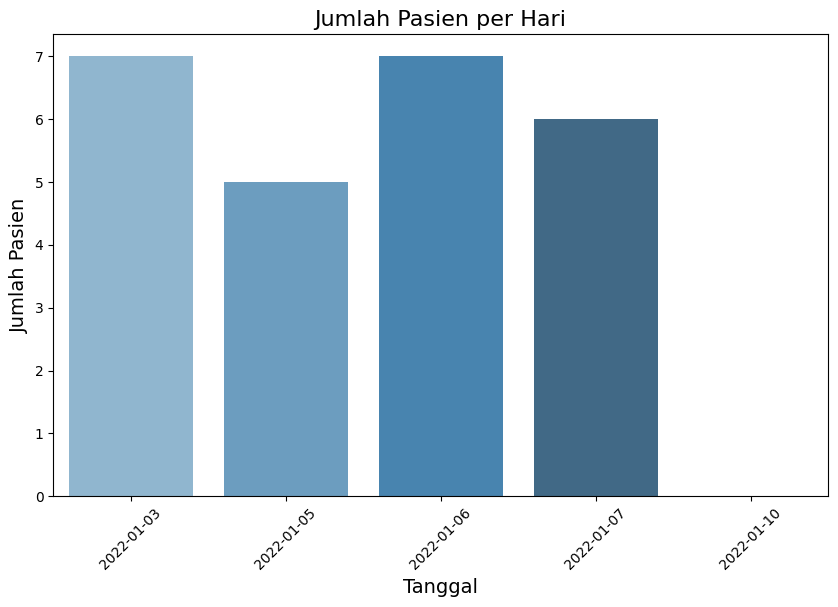

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Membuat dictionary untuk menyimpan jumlah pasien per hari
patient_count_per_day = {day: len(schedule) for day, schedule in daily_schedules.items()}

# Mengubah dictionary menjadi dataframe agar mudah diproses
df_patient_count = pd.DataFrame(list(patient_count_per_day.items()), columns=['Date', 'Patient_Count'])

# Mengurutkan data berdasarkan tanggal
df_patient_count['Date'] = pd.to_datetime(df_patient_count['Date'])
df_patient_count = df_patient_count.sort_values(by='Date')

# Plotting menggunakan seaborn dan matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x='Date', y='Patient_Count', data=df_patient_count, palette='Blues_d')

# Menambahkan judul dan label
plt.title('Jumlah Pasien per Hari', fontsize=16)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Jumlah Pasien', fontsize=14)
plt.xticks(rotation=45)  # Untuk memutar label tanggal agar terbaca

# Menampilkan grafik
plt.show()
